In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import GPy

from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import display
GPy.plotting.change_plotting_library('matplotlib')

# Helpers

In [2]:
def filter_by_coordinates(data, coordinate_limits):
    """
    Returns the filtered coordinates from the dataset.
    
    Params:
        - coordinate_limits (tuple): in the format (MIN_LAT, MIN_LNG, MAX_LAT, MAX_LNG)
    
    Returns:
        - numpy matrix that consists only of the filtered data
    """ 
    min_lat, min_lng, max_lat, max_lng = coordinate_limits
    
    f1 = data[data[:, 0] > min_lat]
    f2 = f1[f1[:, 0] < max_lat]
    f3 = f2[f2[:, 1] > min_lng]
    f4 = f3[f3[:, 1] < max_lng]

    return f4

def load_data(filename, coordinates):
    data = filter_by_coordinates(np.load(filename), coordinates)    
    X, y = data[:,0:3], data[:,3]
    
    return X, y

def run_gp(dataset, kernel, coordinates):
    """
    Runs the entire GP as a single method and returns the trained model. It is possible to continue
    training it with restarts after the initial training.
    
    Params:
        - dataset (str): name of dataset in `.npy` format to train the GP
        - kernel: GPy kernel object that defines the covariance function of our GP
        - top_left (tuple): (LAT, LNG) of the top left corner of our area concerned
        - bottom_right (tuple): (LAT, LNG) of the bottom right corner of our area concerned

    Returns:
        - a trained GPy model
    """
    X, y = load_data(dataset, coordinates)
    
    print('Training GP...')
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')
    
    model = GPy.models.GPRegression(X, y[:,None], kernel)
    model.optimize(messages=True)
    
    display(model)
    print('Log Likelihood: ' + str(model.log_likelihood()))
    
    return model

# Kernel

Define your kernel here.

In [3]:
def get_kernel():
    return GPy.kern.RBF(1, active_dims=[0]) + GPy.kern.RBF(1, active_dims=[1]) + GPy.kern.StdPeriodic(1, active_dims=[2])

# Datasets

Store your datasets as a list of strings.

In [4]:
sizes = [200, 400]
sk_datasets = [f'../data/sk-filtered_data-{size}.npy' for size in sizes]
tp_datasets =[f'../data/tp-filtered_data-{size}.npy' for size in sizes]

# Tampines

In [5]:
MAX_AREA = (1.351800, 103.943283, 1.360377, 103.957675)

tp_models = []
for dataset in tp_datasets:
    model = run_gp(dataset, get_kernel(), MAX_AREA)
    tp_models += [model]

Training GP...
X shape: (2304, 3)
y shape: (2304,)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    16s44  0006   5.464572e+03   2.366003e+10 
    54s91  0020   5.402096e+03   8.060104e+10 
 01m56s67  0041   5.395952e+03   9.570436e+02 
Runtime:  01m56s67
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.mul.Mat32.variance,1.01090847765,+ve,
sum.mul.Mat32.lengthscale,0.997653183935,+ve,
sum.mul.Mat32_1.variance,1.01090847765,+ve,
sum.mul.Mat32_1.lengthscale,0.980664280085,+ve,
sum.std_periodic.variance,0.997651260202,+ve,
sum.std_periodic.period,0.0975330398441,+ve,
sum.std_periodic.lengthscale,1.00646673103,+ve,
Gaussian_noise.variance,6.29721544612,+ve,


Log Likelihood: -5395.95218294
Training GP...
X shape: (1552, 3)
y shape: (1552,)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    03s79  0004   1.924721e+04   2.434813e+10 
    19s33  0019   5.974657e+03   1.249080e+07 
    20s52  0020   5.806734e+03   1.866835e+07 
 01m02s51  0061   5.669945e+03   1.159184e+05 
 01m03s44  0062   5.669945e+03   1.159184e+05 
Runtime:  01m03s44
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.mul.Mat32.variance,1.17665571052,+ve,
sum.mul.Mat32.lengthscale,0.898764369491,+ve,
sum.mul.Mat32_1.variance,1.17665571052,+ve,
sum.mul.Mat32_1.lengthscale,0.800830030691,+ve,
sum.std_periodic.variance,1.00695329308,+ve,
sum.std_periodic.period,0.953895071349,+ve,
sum.std_periodic.lengthscale,1.00444862438,+ve,
Gaussian_noise.variance,86.4049706078,+ve,


Log Likelihood: -5669.94502377


# Sengkang

In [6]:
MAX_AREA = (1.382030, 103.888635, 1.402076, 103.909292)

sk_models = []
for dataset in sk_datasets:
    model = run_gp(dataset, get_kernel(), MAX_AREA)
    sk_models += [model]

Training GP...
X shape: (2904, 3)
y shape: (2904,)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   6.293098e+03           nan 
    23s56  0006   5.491201e+03   1.132965e+08 
 01m16s74  0020   5.482435e+03   6.552514e+03 
 02m01s28  0032   5.180756e+03   1.469524e+07 
Runtime:  02m01s28
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.Mat32.variance,1.11970113786,+ve,
sum.Mat32.lengthscale,0.776677445157,+ve,
sum.Mat32_1.variance,2.92519862281,+ve,
sum.Mat32_1.lengthscale,0.011872737956,+ve,
sum.std_periodic.variance,0.893129083112,+ve,
sum.std_periodic.period,1.00033548346,+ve,
sum.std_periodic.lengthscale,1.32696463119,+ve,
Gaussian_noise.variance,2.39907401444,+ve,


Log Likelihood: -5180.75639424
Training GP...
X shape: (2820, 3)
y shape: (2820,)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    13s60  0003   1.014089e+04   1.958732e+09 
    25s50  0006   8.479575e+03   1.371141e+08 
 01m22s68  0021   7.584031e+03   5.825669e+08 
 02m20s40  0035   7.584605e+03   6.980663e+06 
 03m33s27  0054   7.347983e+03   6.138414e+12 
 03m45s97  0058   7.141890e+03   2.462272e+04 
Runtime:  03m45s97
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.Mat32.variance,1.00741966984,+ve,
sum.Mat32.lengthscale,0.994043945399,+ve,
sum.Mat32_1.variance,2.09394107648,+ve,
sum.Mat32_1.lengthscale,0.0222632656956,+ve,
sum.std_periodic.variance,0.995396405753,+ve,
sum.std_periodic.period,1.04024829055,+ve,
sum.std_periodic.lengthscale,1.02125598627,+ve,
Gaussian_noise.variance,9.42560807094,+ve,


Log Likelihood: -7141.89011446


# Analysis of models

In [7]:
print('Tampines')
for dataset, model in zip(tp_datasets, sk_models):
    print(f'{dataset}: {model.log_likelihood()}')
    
print('Sengkang')
for dataset, model in zip(sk_datasets, tp_models):
    print(f'{dataset}: {model.log_likelihood()}')

Tampines
../data/tp-filtered_data-200.npy: -5180.756394235261
../data/tp-filtered_data-400.npy: -7141.89011446258
Sengkang
../data/sk-filtered_data-200.npy: -5395.952182938733
../data/sk-filtered_data-400.npy: -5669.9450237723895


 /Users/ianngiaw/Envs/cs4246/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


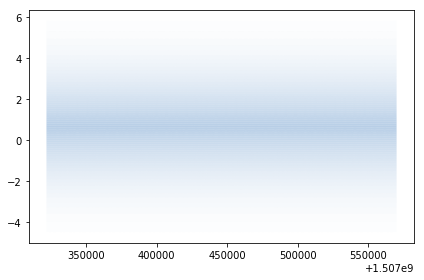

In [8]:
sk_models[0].plot_density(visible_dims=[2])

# Prediction

Let's run some predictions using our trained models.

In [9]:
def predict(model, dataset):
    X, y = load_data()

In [10]:
test_sk_datasets = [f'../data/test-sk-filtered_data-{size}.npy' for size in sizes]
test_tp_datasets =[f'../data/test-tp-filtered_data-{size}.npy' for size in sizes]

## Tampines

In [11]:
MAX_AREA = (1.351800, 103.943283, 1.360377, 103.957675)
for dataset, model in zip(test_tp_datasets, tp_models):
    print('Predicting for dataset:' + dataset)
    X, y = load_data(dataset, MAX_AREA)
    pred_y = model.predict(X)    
    print(mean_squared_error(y, pred_y[0]))
    print(r2_score(y, pred_y[0]))

Predicting for dataset:../data/test-tp-filtered_data-200.npy
6.24448579665
0.00112219814782
Predicting for dataset:../data/test-tp-filtered_data-400.npy
86.2070366402
-6.17382400967e-05


## Sengkang

In [12]:
MAX_AREA = (1.382030, 103.888635, 1.402076, 103.909292)
for dataset, model in zip(test_sk_datasets, sk_models):
    print('Predicting for dataset:' + dataset)
    X, y = load_data(dataset, MAX_AREA)
    pred_y = model.predict(X)    
    print(mean_squared_error(y, pred_y[0]))
    print(r2_score(y, pred_y[0]))

Predicting for dataset:../data/test-sk-filtered_data-200.npy
1.98597695679
0.234387415099
Predicting for dataset:../data/test-sk-filtered_data-400.npy
8.97080193833
0.4658252943
